In [1]:
# Import libraries
import numpy as np
import pandas as pd
import scipy
from scipy import special
from pathlib import Path
import math 
import scipy.stats as scs
from scipy import sparse 
from pathlib import Path 

In [3]:
Nout = 100000  # number of out-of-sample scenarios
Nin = 5000     # number of in-sample scenarios
Ns = 5         # number of idiosyncratic scenarios for each systemic

C = 8          # number of credit states

# Read and parse instrument data
instr_data = np.array(pd.read_csv('instrum_data.csv', header=None))
instr_id = instr_data[:, 0]     # ID
driver = instr_data[:, 1]       # credit driver
beta = instr_data[:, 2]         # beta (sensitivity to credit driver)
recov_rate = instr_data[:, 3]   # expected recovery rate
value = instr_data[:, 4]        # value
prob = instr_data[:, 5:(5 + C)] # credit-state migration probabilities (default to AAA)
exposure = instr_data[:, 5 + C:5 + 2 * C]  # credit-state migration exposures (default to AAA)
retn = instr_data[:, 5 + 2 * C] # market returns

K = instr_data.shape[0]         # number of CPs

# Read matrix of correlations for credit drivers
rho = np.array(pd.read_csv('credit_driver_corr.csv', sep='\t', header=None))
# Cholesky decomp of rho (for generating correlated Normal random numbers)
sqrt_rho = np.linalg.cholesky(rho)

print('======= Credit Risk Model with Credit-State Migrations =======')
print('============== Monte Carlo Scenario Generation ===============')
print(' ')
print(' ')
print(' Number of out-of-sample Monte Carlo scenarios = ' + str(Nout))
print(' Number of in-sample Monte Carlo scenarios = ' + str(Nin))
print(' Number of counterparties = ' + str(K))
print(' ')

# Find credit-state for each counterparty
# 8 = AAA, 7 = AA, 6 = A, 5 = BBB, 4 = BB, 3 = B, 2 = CCC, 1 = default
CS = np.argmax(prob, axis=1) + 1

# Account for default recoveries
exposure[:, 0] = (1 - recov_rate) * exposure[:, 0]

# Compute credit-state boundaries
CS_Bdry = scipy.special.ndtri((np.cumsum(prob[:, 0:C - 1], 1)))

# -------- Insert your code here -------- #
Ndrivers = len(rho)  #number of credit drivers
filename_save_out = 'Losses_out'
if Path(filename_save_out+'.npz').is_file():
    Losses_out = scipy.sparse.load_npz(filename_save_out + '.npz')
else:
    # Generating Scenarios

    # -------- Insert your code here -------- #
    y = np.zeros((Nout, Ndrivers))     #zero array for parameter systemic credit driver factor
    w = np.zeros((Nout,K))             #zero array for creditworthiness index
    Losses_out = np.zeros((Nout, K))
    for s in range(1, Nout + 1):
        # -------- Insert your code here -------- #
        random_normal_factor = np.random.normal(0,1,(Ndrivers, 1))   # random Normal distribution factor 
        y[s-1,:] = np.dot(sqrt_rho, random_normal_factor).T
        z = np.random.normal(0,1,(K,1))                             # Idiosyncratic component as normal distribution with mean = 0 & variance = 1        
        for k in range(1, K+1):
            cd = int(driver[k-1])        #corresponding credit driver 
            #compute credit worthiness index 
            w[s-1,k-1] = beta[k-1] * y[s-1,cd-1] + np.sqrt(1 - beta[k-1]**2) * z[k-1]  # formula wj = Bj*yj(k)+sqrt(1-Bj^2)*zj
            credit_map = np.append(w[s-1,k-1], CS_Bdry[k-1,:])        # credit-state boundaries and w 
            credit_level = np.sort(credit_map)                      #sort the credit map from lowest 
            credit_index = np.argwhere(credit_level == w[s-1,k-1])     #find the index
        # Calculated out-of-sample losses (100000 x 100)
            Losses_out[s-1,k-1] = exposure[k-1, credit_index]
        
        # Losses_out (sparse matrix)
    Losses_out = sparse.csr_matrix(Losses_out)
    scipy.sparse.save_npz(filename_save_out + '.npz', Losses_out)    

======= Credit Risk Model with Credit-State Migrations =======
============== Monte Carlo Scenario Generation ===============
 
 
 Number of out-of-sample Monte Carlo scenarios = 100000
 Number of in-sample Monte Carlo scenarios = 5000
 Number of counterparties = 100
 


In [6]:
rho.shape, instr_data.shape

((50, 50), (100, 22))

In [19]:
# Normal approximation computed from out-of-sample scenarios
mu_l = np.mean(Losses_out, axis=0).reshape((K))
var_l = np.cov(Losses_out.toarray(), rowvar=False) # Losses_out as a sparse matrix

# Compute portfolio weights
portf_v = sum(value)  # portfolio value
w0 = []
w0.append(value / portf_v)   # asset weights (portfolio 1)
w0.append(np.ones((K)) / K)  # asset weights (portfolio 2)
x0 = []
x0.append((portf_v / value) * w0[0])  # asset units (portfolio 1)
x0.append((portf_v / value) * w0[1])  # asset units (portfolio 2)

# Quantile levels (99%, 99.9%)
alphas = np.array([0.99, 0.999])

VaRout = np.zeros((2, alphas.size))
VaRinN = np.zeros((2, alphas.size))
CVaRout = np.zeros((2, alphas.size))
CVaRinN = np.zeros((2, alphas.size))

Losses_out_port = []
Losses_out_port.append(np.sort(Losses_out*x0[0]))  #Sorted the total loss from lowest using asset units of portfolio 1
Losses_out_port.append(np.sort(Losses_out*x0[1]))  #Sorted the total loss from lowest using asset units of portfolio 2


for portN in range(2):
    # Compute VaR and CVaR
    for q in range(alphas.size):
        alf = alphas[q]
        # -------- Insert your code here -------- #

        VaRout[portN, q] = Losses_out_port[portN][int(math.ceil(Nout*alf))-1]
        VaRinN[portN, q] = np.mean(Losses_out_port[portN]+ scs.norm.ppf(alf)*np.std(Losses_out_port[portN]))
        CVaRout[portN, q] = (1/(Nout*(1-alf)) * ((math.ceil(Nout*alf) - Nout*alf) 
                                                 * VaRout[portN,q] 
                                                 + sum(Losses_out_port[portN][int(math.ceil(Nout*alf)):])))
        CVaRinN[portN, q] = np.mean(Losses_out_port[portN]) + (scs.norm.pdf(scs.norm.ppf(alf)) 
                                                               / (1 - alf)) * np.std(Losses_out_port[portN])

# Perform 100 trials
N_trials = 100

VaRinMC1 = {}
VaRinMC2 = {}
VaRinN1 = {}
VaRinN2 = {}
CVaRinMC1 = {}
CVaRinMC2 = {}
CVaRinN1 = {}
CVaRinN2 = {}

portf_loss_inMC1 = np.zeros((N_trials, 2, Nin))
portf_loss_inMC2 = np.zeros((N_trials, 2, Nin))
                             
for portN in range(2):
    for q in range(alphas.size):
        VaRinMC1[portN, q] = np.zeros(N_trials)
        VaRinMC2[portN, q] = np.zeros(N_trials)
        VaRinN1[portN, q] = np.zeros(N_trials)
        VaRinN2[portN, q] = np.zeros(N_trials)
        CVaRinMC1[portN, q] = np.zeros(N_trials)
        CVaRinMC2[portN, q] = np.zeros(N_trials)
        CVaRinN1[portN, q] = np.zeros(N_trials)
        CVaRinN2[portN, q] = np.zeros(N_trials)



In [26]:
for tr in range(1, N_trials + 1):
    # Monte Carlo approximation 1

    # -------- Insert your code here -------- #
    y_inMC1 = np.zeros((np.int(np.ceil(Nin/Ns)), Ndrivers))
    w_inMC1 = np.zeros((np.int(np.ceil(Nin/Ns)), Ns, K))
    Losses_inMC1 = np.zeros((Nin,K))
    Losses_MC1_per = np.zeros((np.int(np.ceil(Nin/Ns)), Ns, K))
    i = 0

    for s in range(1, np.int(np.ceil(Nin / Ns) + 1)): # systemic scenarios
        # -------- Insert your code here -------- #
        normal_random_factor = np.random.normal(0,1,(Ndrivers, 1))
        y_inMC1[s-1,:] = np.dot(sqrt_rho, normal_random_factor).T
        
        for si in range(1, Ns + 1): # idiosyncratic scenarios for each systemic
            # -------- Insert your code here -------- #
            z_MC1 = np.random.normal(0,1,(K,1))

            # Calculate losses for MC1 approximation (5000 x 100)
            for k in range(1,K+1):
                cd = int(driver[k-1])
                w_inMC1[s-1,si-1,k-1] = beta[k-1]*y_inMC1[s-1,cd-1] + math.sqrt(1-beta[k-1]**2)*z_MC1[k-1]
                credit_map_MC1 = np.append(w_inMC1[s-1, si-1][k-1], CS_Bdry[k-1,:])
                credit_level = np.sort(credit_map_MC1)
                credit_index = np.argwhere(credit_level == w_inMC1[s-1,si-1][k-1])
                #calculate in-sample losses (1000x5x100)
                Losses_MC1_per[s-1,si-1,k-1] = exposure[k-1, credit_index]
    # Losses_inMC1
            Losses_inMC1[i,:] = Losses_MC1_per[s-1,si-1]
            i+=1

    # Monte Carlo approximation 2
  
    # -------- Insert your code here -------- #
    w_inMC2 = np.zeros((Nin, K))
    y_inMC2 = np.zeros((Nin, Ndrivers))
    Losses_inMC2 = np.zeros((Nin,K))

    for s in range(1, Nin + 1): # systemic scenarios (1 idiosyncratic scenario for each systemic)
        # -------- Insert your code here -------- #
        normal_random_factor = np.random.normal(0,1,(Ndrivers,1))
        y_inMC2[s-1:] = np.dot(sqrt_rho, normal_random_factor).T
        z_MC2 = np.random.normal(0,1,(K,1))

        # Calculated losses for MC2 approximation (5000 x 100)
        for k in range(1,K+1):
            cd = int(driver[k-1])
            w_inMC2[s-1,k-1] = beta[k-1]*y_inMC2[s-1,cd-1] + math.sqrt(1-beta[k-1]**2)*z_MC2[k-1]
            credit_map_MC2 = np.append(w_inMC2[s-1,k-1], CS_Bdry[k-1,:])
            credit_level = np.sort(credit_map_MC2)
            credit_index = np.argwhere(credit_level == w_inMC2[s-1,k-1])
            #calculate in-sample losses (5000x100) Losses_inMC2
            Losses_inMC2[s-1,k-1] = exposure[k-1, credit_index]


    # Compute VaR and CVaR

    for portN in range(2):
        for q in range(alphas.size):
            alf = alphas[q]
            # -------- Insert your code here -------- #
            # Compute portfolio loss
            portf_loss_inMC1[tr-1, portN] = np.sort(np.dot(Losses_inMC1, x0[portN]))
            portf_loss_inMC2[tr-1, portN] = np.sort(np.dot(Losses_inMC2, x0[portN]))
            mu_MC1 = np.mean(Losses_inMC1, axis=0).reshape((K))
            var_MC1 = np.cov(Losses_inMC1, rowvar=False)
            mu_MC2 = np.mean(Losses_inMC2, axis=0).reshape((K))
            var_MC2 = np.cov(Losses_inMC2, rowvar=False)
            # Compute portfolio mean loss mu_p_MC1 and portfolio standard deviation of losses sigma_p_MC1
            mu_p_MC1 = np.dot(mu_MC1, x0[portN])
            sigma_p_MC1 = np.std(portf_loss_inMC1[tr-1,portN])
            # Compute portfolio mean loss mu_p_MC2 and portfolio standard deviation of losses sigma_p_MC2
            mu_p_MC2 =  np.dot(mu_MC2, x0[portN])
            sigma_p_MC2 = np.std(portf_loss_inMC2[tr-1,portN])
            # Compute VaR and CVaR for the current trial
            VaRinMC1[portN, q][tr - 1] = portf_loss_inMC1[tr-1, portN][int(math.ceil(Nin *alf)) -1]
            VaRinMC2[portN, q][tr - 1] = portf_loss_inMC2[tr-1, portN][int(math.ceil(Nin *alf)) -1]
            VaRinN1[portN, q][tr - 1] =  np.mean(portf_loss_inMC1[tr-1, portN]) + scs.norm.ppf(alf)*sigma_p_MC1 
            VaRinN2[portN, q][tr - 1] =  np.mean(portf_loss_inMC2[tr-1, portN]) + scs.norm.ppf(alf)*sigma_p_MC2
            CVaRinMC1[portN, q][tr - 1] = (1 / (Nin * (1 - alf))) * ((math.ceil(Nin * alf) - Nin * alf) * VaRinMC1[portN, q][tr-1] + sum(portf_loss_inMC1[tr-1, portN][int(math.ceil(Nin * alf)):]))
            CVaRinMC2[portN, q][tr - 1] = (1 / (Nin * (1 - alf))) * ((math.ceil(Nin * alf) - Nin * alf) * VaRinMC2[portN, q][tr-1] + sum(portf_loss_inMC2[tr-1, portN][int(math.ceil(Nin * alf)):]))
            CVaRinN1[portN, q][tr - 1] =  np.mean(portf_loss_inMC1[tr-1, portN]) + (scs.norm.pdf(scs.norm.ppf(alf))/ (1-alf)) * sigma_p_MC1
            CVaRinN2[portN, q][tr - 1] =  np.mean(portf_loss_inMC2[tr-1, portN]) + (scs.norm.pdf(scs.norm.ppf(alf))/ (1-alf)) * sigma_p_MC2



In [27]:
# Display VaR and CVaR
for portN in range(2):
    print('\nPortfolio {}:\n'.format(portN + 1))
    for q in range(alphas.size):
        alf = alphas[q]
        print('Out-of-sample: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRout[portN, q], 100 * alf, CVaRout[portN, q]))
        print('In-sample MC1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC1[portN, q]), 100 * alf, np.mean(CVaRinMC1[portN, q])))
        print('In-sample MC2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC2[portN, q]), 100 * alf, np.mean(CVaRinMC2[portN, q])))
        print('In-sample No: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRinN[portN, q], 100 * alf, CVaRinN[portN, q]))
        print('In-sample N1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinN1[portN, q]), 100 * alf, np.mean(CVaRinN1[portN, q])))
        print('In-sample N2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f\n' % (
        100 * alf, np.mean(VaRinN2[portN, q]), 100 * alf, np.mean(CVaRinN2[portN, q])))




Portfolio 1:

Out-of-sample: VaR 99.0% = $37668009.00, CVaR 99.0% = $45434628.99
In-sample MC1: VaR 99.0% = $37254411.71, CVaR 99.0% = $44714065.19
In-sample MC2: VaR 99.0% = $36997505.76, CVaR 99.0% = $44555137.57
In-sample No: VaR 99.0% = $26341979.95, CVaR 99.0% = $29250839.69
In-sample N1: VaR 99.0% = $26182840.59, CVaR 99.0% = $29070565.97
In-sample N2: VaR 99.0% = $26153088.26, CVaR 99.0% = $29037641.23

Out-of-sample: VaR 99.9% = $55197450.92, CVaR 99.9% = $63751102.95
In-sample MC1: VaR 99.9% = $53885863.74, CVaR 99.9% = $61069345.64
In-sample MC2: VaR 99.9% = $53736938.80, CVaR 99.9% = $61650490.34
In-sample No: VaR 99.9% = $32899233.86, CVaR 99.9% = $35275806.32
In-sample N1: VaR 99.9% = $32692452.66, CVaR 99.9% = $35051758.09
In-sample N2: VaR 99.9% = $32655549.00, CVaR 99.9% = $35012262.54


Portfolio 2:

Out-of-sample: VaR 99.0% = $27507296.24, CVaR 99.0% = $33947339.63
In-sample MC1: VaR 99.0% = $27417068.27, CVaR 99.0% = $33372015.56
In-sample MC2: VaR 99.0% = $27337376

In [130]:
print('Sampling error for portfolio 1:\n')
se_p1_Va99_mc1 = (100*((np.mean(VaRinMC1[0,0])/VaRout[0,0]) -1))
se_p1_CVa99_mc1 = (100*((np.mean(CVaRinMC1[0,0])/CVaRout[0,0]) -1))
print('In-sample MC1: VaR 99% = {}%, CVaR 99% = {}% '.format(round(se_p1_Va99_mc1,2), round(se_p1_CVa99_mc1,2)))

se_p1_Va99_mc2 = (100*((np.mean(VaRinMC2[0,0])/VaRout[0,0]) -1))
se_p1_CVa99_mc2 = (100*((np.mean(CVaRinMC2[0,0])/CVaRout[0,0]) -1))
print('In-sample MC2: VaR 99% = {}%, CVaR 99% = {}% '.format(round(se_p1_Va99_mc2,2), round(se_p1_CVa99_mc2,2)))

se_p1_Va999_mc1 = (100*((np.mean(VaRinMC1[0,1])/VaRout[0,1]) -1))
se_p1_CVa999_mc1 = (100*((np.mean(CVaRinMC1[0,1])/CVaRout[0,1]) -1))
print('\nIn-sample MC1: VaR 99.9% = {}%, CVaR 99.9% = {}% '.format(round(se_p1_Va999_mc1,2), round(se_p1_CVa999_mc1,2)))

se_p1_Va999_mc2 = (100*((np.mean(VaRinMC2[0,1])/VaRout[0,1]) -1))
se_p1_CVa999_mc2 = (100*((np.mean(CVaRinMC2[0,1])/CVaRout[0,1]) -1))
print('In-sample MC2: VaR 99.9% = {}%, CVaR 99.9% = {}% '.format(round(se_p1_Va999_mc2,2), round(se_p1_CVa999_mc2,2)))


print('===============================================================')

print('Sampling error for portfolio 2:\n')
se_p2_Va99_mc1 = (100*((np.mean(VaRinMC1[1,0])/VaRout[1,0]) -1))
se_p2_CVa99_mc1 = (100*((np.mean(CVaRinMC1[1,0])/CVaRout[1,0]) -1))
print('In-sample MC1: VaR 99% = {}%, CVaR 99% = {}% '.format(round(se_p2_Va99_mc1,2), round(se_p2_CVa99_mc1,2)))

se_p2_Va99_mc2 = (100*((np.mean(VaRinMC2[1,0])/VaRout[1,0]) -1))
se_p2_CVa99_mc2 = (100*((np.mean(CVaRinMC2[1,0])/CVaRout[1,0]) -1))
print('In-sample MC2: VaR 99% = {}%, CVaR 99% = {}% '.format(round(se_p2_Va99_mc2,2), round(se_p2_CVa99_mc2,2)))

se_p2_Va999_mc1 = (100*((np.mean(VaRinMC1[1,1])/VaRout[1,1]) -1))
se_p2_CVa999_mc1 = (100*((np.mean(CVaRinMC1[1,1])/CVaRout[1,1]) -1))
print('\nIn-sample MC1: VaR 99.9% = {}%, CVaR 99.9% = {}% '.format(round(se_p2_Va999_mc1,2), round(se_p2_CVa999_mc1,2)))

se_p2_Va999_mc2 = (100*((np.mean(VaRinMC2[1,1])/VaRout[1,1]) -1))
se_p2_CVa999_mc2 = (100*((np.mean(CVaRinMC2[1,1])/CVaRout[1,1]) -1))
print('In-sample MC2: VaR 99.9% = {}%, CVaR 99.9% = {}% '.format(round(se_p2_Va999_mc2,2), round(se_p2_CVa999_mc2,2)))

Sampling error for portfolio 1:

In-sample MC1: VaR 99% = -1.1%, CVaR 99% = -1.59% 
In-sample MC2: VaR 99% = -1.78%, CVaR 99% = -1.94% 

In-sample MC1: VaR 99.9% = -2.38%, CVaR 99.9% = -4.21% 
In-sample MC2: VaR 99.9% = -2.65%, CVaR 99.9% = -3.3% 
Sampling error for portfolio 2:

In-sample MC1: VaR 99% = -0.33%, CVaR 99% = -1.69% 
In-sample MC2: VaR 99% = -0.62%, CVaR 99% = -1.59% 

In-sample MC1: VaR 99.9% = -3.56%, CVaR 99.9% = -6.84% 
In-sample MC2: VaR 99.9% = -3.72%, CVaR 99.9% = -3.62% 


In [131]:
print('Modeling error for portfolio 1:\n')
me_p1_Va99_N = (100*((VaRinN[0,0]/VaRout[0,0]) -1))
me_p1_CVa99_N =(100*((CVaRinN[0,0]/CVaRout[0,0]) -1))
print('In-sample N:  VaR 99% = {}%, CVaR 99% = {}% '.format(round(me_p1_Va99_N,2), round(me_p1_CVa99_N,2)))

me_p1_Va99_N1 = (100*((np.mean(VaRinN1[0,0])/VaRout[0,0]) -1))
me_p1_CVa99_N1 = (100*((np.mean(CVaRinN1[0,0])/CVaRout[0,0]) -1))
print('In-sample N1: VaR 99% = {}%, CVaR 99% = {}% '.format(round(me_p1_Va99_N1,2), round(me_p1_CVa99_N1,2)))

me_p1_Va99_N2 =(100*((np.mean(VaRinN2[0,0])/VaRout[0,0]) -1))
me_p1_CVa99_N2 = (100*((np.mean(CVaRinN2[0,0])/CVaRout[0,0]) -1))
print('In-sample N2: VaR 99% = {}%, CVaR 99% = {}% '.format(round(me_p1_Va99_N2,2), round(me_p1_CVa99_N2,2)))


me_p1_Va999_N = (100*((VaRinN[0,1]/VaRout[0,1]) -1))
me_p1_CVa999_N = (100*((CVaRinN[0,1]/CVaRout[0,1]) -1))
print('\nIn-sample N:  VaR 99.9% = {}%, CVaR 99.9% = {}% '.format(round(me_p1_Va999_N,2), round(me_p1_CVa999_N,2)))

me_p1_Va999_N1 = (100*((np.mean(VaRinN1[0,1])/VaRout[0,1]) -1))
me_p1_CVa999_N1 = (100*((np.mean(CVaRinN1[0,1])/CVaRout[0,1]) -1))
print('In-sample N1: VaR 99.9% = {}%, CVaR 99.9% = {}% '.format(round(me_p1_Va999_N1,2), round(me_p1_CVa999_N1,2)))

me_p1_Va999_N2 = (100*((np.mean(VaRinN2[0,1])/VaRout[0,1]) -1))
me_p1_CVa999_N2 = (100*((np.mean(CVaRinN2[0,1])/CVaRout[0,1]) -1))
print('In-sample N2: VaR 99.9% = {}%, CVaR 99.9% = {}% '.format(round(me_p1_Va999_N2,2), round(me_p1_CVa999_N2,2)))




print('===================================================================================')


print('Modeling error for portfolio 2:\n')
me_p2_Va99_N = (100*((VaRinN[1,0]/VaRout[1,0]) -1))
me_p2_CVa99_N = (100*((CVaRinN[1,0]/CVaRout[1,0]) -1))
print('In-sample N:  VaR 99% = {}%, CVaR 99% = {}% '.format(round(me_p2_Va99_N,2), round(me_p2_CVa99_N,2)))

me_p2_Va99_N1 = (100*((np.mean(VaRinN1[1,0])/VaRout[1,0]) -1))
me_p2_CVa99_N1 = (100*((np.mean(CVaRinN1[1,0])/CVaRout[1,0]) -1))
print('In-sample N1: VaR 99% = {}%, CVaR 99% = {}% '.format(round(me_p2_Va99_N1,2), round(me_p2_CVa99_N1,2)))

me_p2_Va99_N2 = (100*((np.mean(VaRinN2[1,0])/VaRout[1,0]) -1))
me_p2_CVa99_N2 = (100*((np.mean(CVaRinN2[1,0])/CVaRout[1,0]) -1))
print('In-sample N2: VaR 99% = {}%, CVaR 99% = {}% '.format(round(me_p2_Va99_N2,2), round(me_p2_CVa99_N2,2)))


me_p2_Va999_N = (100*((VaRinN[1,1]/VaRout[1,1]) -1))
me_p2_CVa999_N = (100*((CVaRinN[1,1]/CVaRout[1,1]) -1))
print('\nIn-sample N:  VaR 99.9% = {}%, CVaR 99.9% = {}% '.format(round(me_p2_Va999_N,2), round(me_p2_CVa999_N,2)))

me_p2_Va999_N1 = (100*((np.mean(VaRinN1[1,1])/VaRout[1,1]) -1))
me_p2_CVa999_N1 = (100*((np.mean(CVaRinN1[1,1])/CVaRout[1,1]) -1))
print('In-sample N1: VaR 99.9% = {}%, CVaR 99.9% = {}% '.format(round(me_p2_Va999_N1,2), round(me_p2_CVa999_N1,2)))

me_p2_Va999_N2 = (100*((np.mean(VaRinN2[1,1])/VaRout[1,1]) -1))
me_p2_CVa999_N2 = (100*((np.mean(CVaRinN2[1,1])/CVaRout[1,1]) -1))
print('In-sample N2: VaR 99.9% = {}%, CVaR 99.9% = {}% '.format(round(me_p2_Va999_N2,2), round(me_p2_CVa999_N2,2)))

Modeling error for portfolio 1:

In-sample N:  VaR 99% = -30.07%, CVaR 99% = -35.62% 
In-sample N1: VaR 99% = -30.49%, CVaR 99% = -36.02% 
In-sample N2: VaR 99% = -30.57%, CVaR 99% = -36.09% 

In-sample N:  VaR 99.9% = -40.4%, CVaR 99.9% = -44.67% 
In-sample N1: VaR 99.9% = -40.77%, CVaR 99.9% = -45.02% 
In-sample N2: VaR 99.9% = -40.84%, CVaR 99.9% = -45.08% 
Modeling error for portfolio 2:

In-sample N:  VaR 99% = -22.66%, CVaR 99% = -30.89% 
In-sample N1: VaR 99% = -23.38%, CVaR 99% = -31.55% 
In-sample N2: VaR 99% = -23.32%, CVaR 99% = -31.49% 

In-sample N:  VaR 99.9% = -38.35%, CVaR 99.9% = -43.76% 
In-sample N1: VaR 99.9% = -38.96%, CVaR 99.9% = -44.32% 
In-sample N2: VaR 99.9% = -38.9%, CVaR 99.9% = -44.26% 


## Portfolio 1 
### 1) Out of Sample vs Normal 

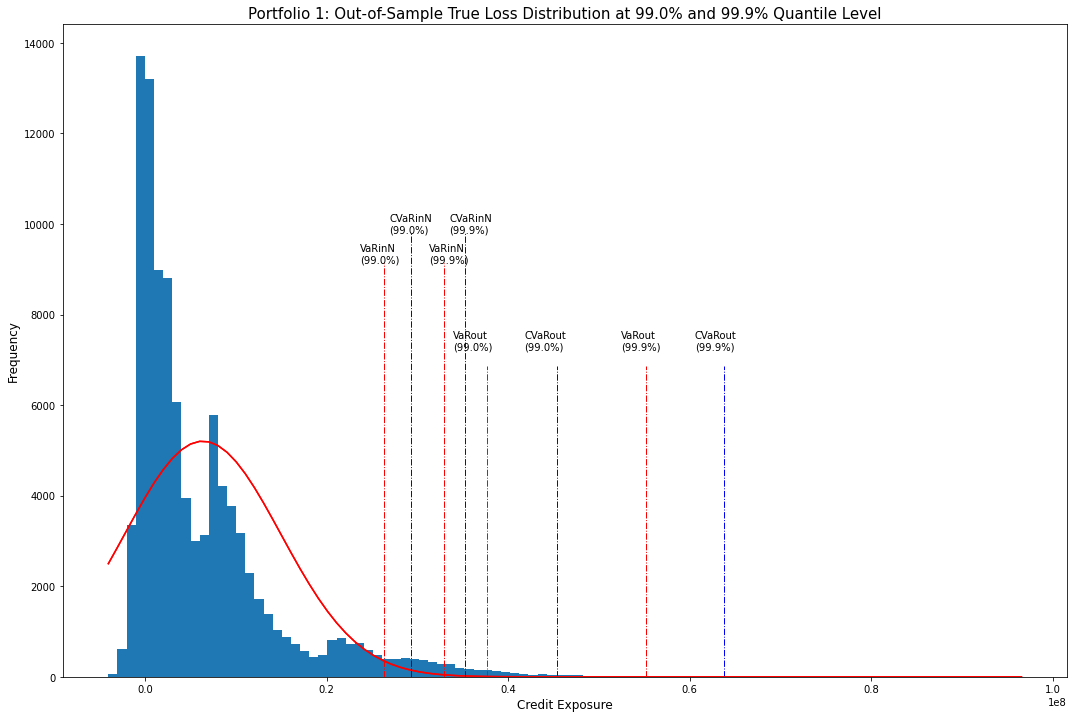

In [126]:
import matplotlib.pyplot as plt
# Plot results
# Figure (1):
# -------- Insert your code here -------- #
# out of sample port lost distribution for port 1, N =100,000
plt.figure(figsize=(18,12))
frequencyCounts, binLocations, patches = plt.hist(Losses_out_port[0], 100)
normf = (1 / (np.std(Losses_out_port[0]) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(Losses_out_port[0])) / np.std(Losses_out_port[0])) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)

# Plot non-Normal VaR and CVaR at 99.0% and 99.9% quantile
plt.plot(binLocations, normf, color='r', linewidth=1.5)
plt.plot([VaRout[0,0], VaRout[0,0]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.90 * VaRout[0,0], max(frequencyCounts) / 1.9, 'VaRout\n(99.0%)')
plt.plot([VaRout[0,1], VaRout[0,1]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRout[0,1], max(frequencyCounts) / 1.9, 'VaRout\n(99.9%)')
plt.plot([CVaRout[0,0], CVaRout[0,0]], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.text(0.92 * CVaRout[0,0], max(frequencyCounts) / 1.9, 'CVaRout\n(99.0%)')
plt.plot([CVaRout[0,1], CVaRout[0,1]], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.text(0.95 * CVaRout[0,1], max(frequencyCounts) / 1.9, 'CVaRout\n(99.9%)')

# Plot Normal VaR and CVaR at 99.0% and 99.9% quantile
plt.plot(binLocations, normf, color='r', linewidth=1.5)
plt.plot([VaRinN[0,0], VaRinN[0,0]], [0, max(frequencyCounts)/1.5], color='r', linewidth=1, linestyle='-.')
plt.text(0.90 * VaRinN[0,0], max(frequencyCounts) / 1.5, 'VaRinN\n(99.0%)')
plt.plot([VaRinN[0,1], VaRinN[0,1]], [0, max(frequencyCounts)/1.5], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinN[0,1], max(frequencyCounts) / 1.5, 'VaRinN\n(99.9%)')
plt.plot([CVaRinN[0,0], CVaRinN[0,0]], [0, max(frequencyCounts)/1.4], color='b', linewidth=1, linestyle='-.')
plt.text(0.92 * CVaRinN[0,0], max(frequencyCounts) / 1.4, 'CVaRinN\n(99.0%)')
plt.plot([CVaRinN[0,1], CVaRinN[0,1]], [0, max(frequencyCounts)/1.4], color='b', linewidth=1, linestyle='-.')
plt.text(0.95 * CVaRinN[0,1], max(frequencyCounts) / 1.4, 'CVaRinN\n(99.9%)')

plt.title('Portfolio 1: Out-of-Sample True Loss Distribution at 99.0% and 99.9% Quantile Level', fontsize=15)
plt.xlabel('Credit Exposure', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12);
plt.savefig('p1_out.png')

### 2) MC1 vs Normal 

In [98]:
# For in sample Monte Carlo apporximation 1, 2 
# Compute average of loss for each scenario for each portfolio for better plotting of the result

port_loss_inMC1_p1 = np.zeros((5000,))
port_loss_inMC1_p2 = np.zeros((5000,))
port_loss_inMC2_p1 = np.zeros((5000,))
port_loss_inMC2_p2 = np.zeros((5000,))

for i in range(N_trials):                    #Average over 100 trials
    port_loss_inMC1_p1 = port_loss_inMC1_p1 + portf_loss_inMC1[i,0]*0.01
    port_loss_inMC1_p2 = port_loss_inMC1_p2 + portf_loss_inMC1[i,1]*0.01
    port_loss_inMC2_p1 = port_loss_inMC2_p1 + portf_loss_inMC2[i,0]*0.01
    port_loss_inMC2_p2 = port_loss_inMC2_p2 + portf_loss_inMC2[i,1]*0.01

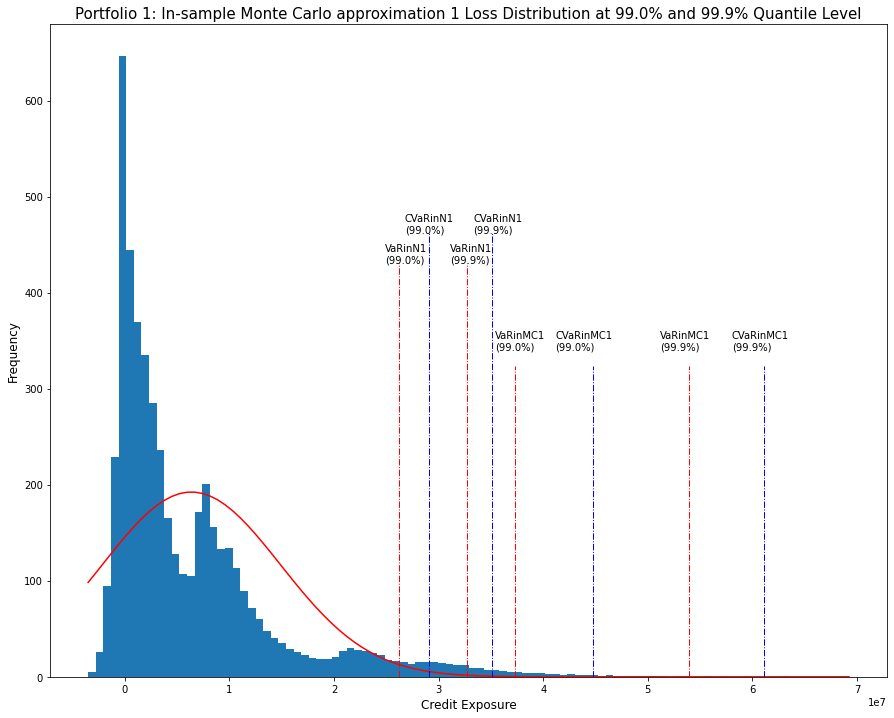

In [99]:
# Plot results
# -------- Insert your code here -------- #
# Distribution of Portfolio 1 Monte Carlo approximation 1, portfolio 1, N = 1000x5
VaRinMC1_p1_99 = np.mean(VaRinMC1[0, 0])
VaRinMC1_p1_99_9 = np.mean(VaRinMC1[0, 1])
CVaRinMC1_p1_99 = np.mean(CVaRinMC1[0, 0])
CVaRinMC1_p1_99_9 = np.mean(CVaRinMC1[0, 1])



plt.figure(figsize=(15,12))
frequencyCounts, binLocations, patches = plt.hist(port_loss_inMC1_p1, 100)
normf = (1 / (np.std(port_loss_inMC1_p1) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(port_loss_inMC1_p1)) / np.std(port_loss_inMC1_p1)) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth=1.5)
plt.plot([VaRinMC1_p1_99, VaRinMC1_p1_99], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinMC1_p1_99, max(frequencyCounts) / 1.9, 'VaRinMC1\n(99.0%)')
plt.plot([VaRinMC1_p1_99_9, VaRinMC1_p1_99_9], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinMC1_p1_99_9, max(frequencyCounts) / 1.9, 'VaRinMC1\n(99.9%)')
plt.plot([CVaRinMC1_p1_99, CVaRinMC1_p1_99], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.text(0.92 * CVaRinMC1_p1_99, max(frequencyCounts) / 1.9, 'CVaRinMC1\n(99.0%)')
plt.plot([CVaRinMC1_p1_99_9, CVaRinMC1_p1_99_9], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.text(0.95 * CVaRinMC1_p1_99_9, max(frequencyCounts) / 1.9, 'CVaRinMC1\n(99.9%)')

# Normal distribution of Monte Carlo approximation 1, portfolio 1 
VaRinN1_p1_99 = np.mean(VaRinN1[0, 0])
VaRinN1_p1_99_9 = np.mean(VaRinN1[0, 1])
CVaRinN1_p1_99 = np.mean(CVaRinN1[0, 0])
CVaRinN1_p1_99_9 = np.mean(CVaRinN1[0, 1])

plt.plot([VaRinN1_p1_99, VaRinN1_p1_99], [0, max(frequencyCounts)/1.5], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinN1_p1_99, max(frequencyCounts) / 1.5, 'VaRinN1\n(99.0%)')
plt.plot([VaRinN1_p1_99_9, VaRinN1_p1_99_9], [0, max(frequencyCounts)/1.5], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinN1_p1_99_9, max(frequencyCounts) / 1.5, 'VaRinN1\n(99.9%)')
plt.plot([CVaRinN1_p1_99, CVaRinN1_p1_99], [0, max(frequencyCounts)/1.4], color='b', linewidth=1, linestyle='-.')
plt.text(0.92 * CVaRinN1_p1_99, max(frequencyCounts) / 1.4, 'CVaRinN1\n(99.0%)')
plt.plot([CVaRinN1_p1_99_9, CVaRinN1_p1_99_9], [0, max(frequencyCounts)/1.4], color='b', linewidth=1, linestyle='-.')
plt.text(0.95 * CVaRinN1_p1_99_9, max(frequencyCounts) / 1.4, 'CVaRinN1\n(99.9%)')


plt.title('Portfolio 1: In-sample Monte Carlo approximation 1 Loss Distribution at 99.0% and 99.9% Quantile Level', fontsize=15)
plt.xlabel('Credit Exposure', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12);
plt.savefig('p1_mc1.png')

### 3) MC2

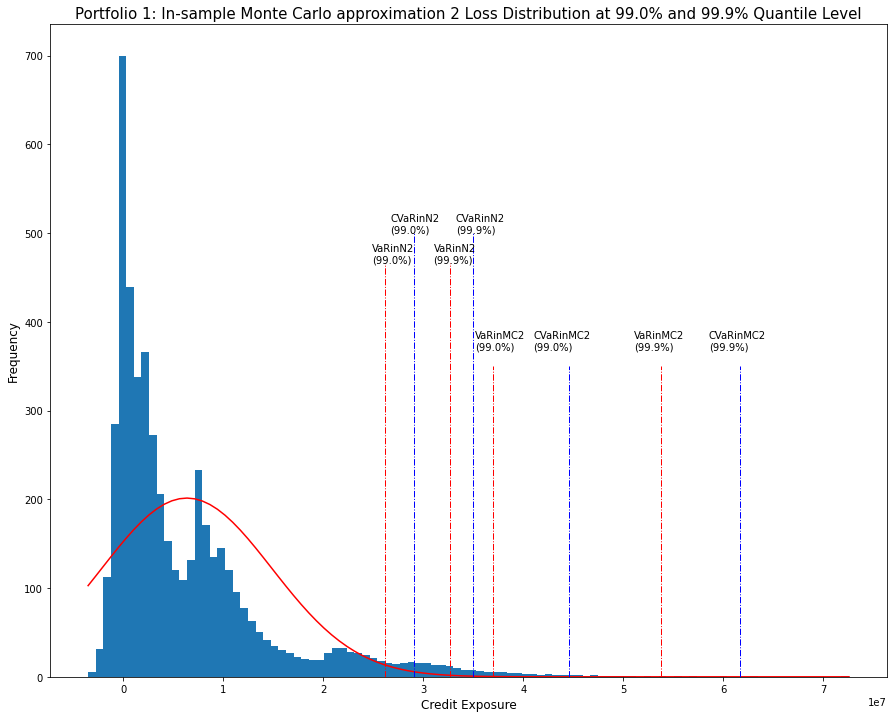

In [100]:
VaRinMC2_p1_99 = np.mean(VaRinMC2[0, 0])
VaRinMC2_p1_99_9 = np.mean(VaRinMC2[0, 1])
CVaRinMC2_p1_99 = np.mean(CVaRinMC2[0, 0])
CVaRinMC2_p1_99_9 = np.mean(CVaRinMC2[0, 1])



plt.figure(figsize=(15,12))
frequencyCounts, binLocations, patches = plt.hist(port_loss_inMC2_p1, 100)
normf = (1 / (np.std(port_loss_inMC2_p1) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(port_loss_inMC2_p1)) / np.std(port_loss_inMC2_p1)) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth=1.5)
plt.plot([VaRinMC2_p1_99, VaRinMC2_p1_99], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinMC2_p1_99, max(frequencyCounts) / 1.9, 'VaRinMC2\n(99.0%)')
plt.plot([VaRinMC2_p1_99_9, VaRinMC2_p1_99_9], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinMC2_p1_99_9, max(frequencyCounts) / 1.9, 'VaRinMC2\n(99.9%)')
plt.plot([CVaRinMC2_p1_99, CVaRinMC2_p1_99], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.text(0.92 * CVaRinMC2_p1_99, max(frequencyCounts) / 1.9, 'CVaRinMC2\n(99.0%)')
plt.plot([CVaRinMC2_p1_99_9, CVaRinMC2_p1_99_9], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.text(0.95 * CVaRinMC2_p1_99_9, max(frequencyCounts) / 1.9, 'CVaRinMC2\n(99.9%)')

# Normal distribution of Monte Carlo approximation 1, portfolio 1 
VaRinN2_p1_99 = np.mean(VaRinN2[0, 0])
VaRinN2_p1_99_9 = np.mean(VaRinN2[0, 1])
CVaRinN2_p1_99 = np.mean(CVaRinN2[0, 0])
CVaRinN2_p1_99_9 = np.mean(CVaRinN2[0, 1])

plt.plot([VaRinN2_p1_99, VaRinN2_p1_99], [0, max(frequencyCounts)/1.5], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinN2_p1_99, max(frequencyCounts) / 1.5, 'VaRinN2\n(99.0%)')
plt.plot([VaRinN2_p1_99_9, VaRinN2_p1_99_9], [0, max(frequencyCounts)/1.5], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinN2_p1_99_9, max(frequencyCounts) / 1.5, 'VaRinN2\n(99.9%)')
plt.plot([CVaRinN2_p1_99, CVaRinN2_p1_99], [0, max(frequencyCounts)/1.4], color='b', linewidth=1, linestyle='-.')
plt.text(0.92 * CVaRinN2_p1_99, max(frequencyCounts) / 1.4, 'CVaRinN2\n(99.0%)')
plt.plot([CVaRinN2_p1_99_9, CVaRinN2_p1_99_9], [0, max(frequencyCounts)/1.4], color='b', linewidth=1, linestyle='-.')
plt.text(0.95 * CVaRinN2_p1_99_9, max(frequencyCounts) / 1.4, 'CVaRinN2\n(99.9%)')


plt.title('Portfolio 1: In-sample Monte Carlo approximation 2 Loss Distribution at 99.0% and 99.9% Quantile Level', fontsize=15)
plt.xlabel('Credit Exposure', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12);
plt.savefig('p1_mc2.png')

## Portfolio 2
### 1) Out-of-Sample

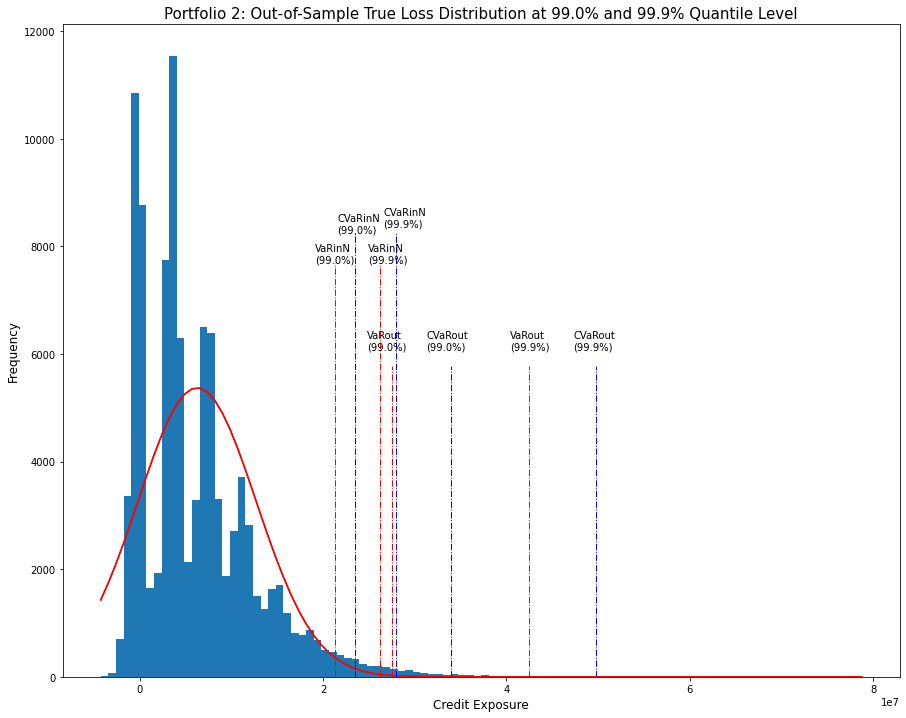

In [101]:
# Figure (2):
# -------- Insert your code here -------- #
plt.figure(figsize=(15,12))
frequencyCounts, binLocations, patches = plt.hist(Losses_out_port[1], 100)
normf = (1 / (np.std(Losses_out_port[1]) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(Losses_out_port[1])) / np.std(Losses_out_port[1])) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth=1.5)

# Plot non-Normal VaR and CVaR at 99.0% and 99.9% quantile
plt.plot([VaRout[1,0], VaRout[1,0]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.90 * VaRout[1,0], max(frequencyCounts) / 1.9, 'VaRout\n(99.0%)')
plt.plot([VaRout[1,1], VaRout[1,1]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRout[1,1], max(frequencyCounts) / 1.9, 'VaRout\n(99.9%)')
plt.plot([CVaRout[1,0], CVaRout[1,0]], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.text(0.92 * CVaRout[1,0], max(frequencyCounts) / 1.9, 'CVaRout\n(99.0%)')
plt.plot([CVaRout[1,1], CVaRout[1,1]], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.text(0.95 * CVaRout[1,1], max(frequencyCounts) / 1.9, 'CVaRout\n(99.9%)')

# Plot Normal VaR and CVaR at 99.0% and 99.9% quantile
plt.plot(binLocations, normf, color='r', linewidth=1.5)
plt.plot([VaRinN[1,0], VaRinN[1,0]], [0, max(frequencyCounts)/1.5], color='r', linewidth=1, linestyle='-.')
plt.text(0.90 * VaRinN[1,0], max(frequencyCounts) / 1.5, 'VaRinN\n(99.0%)')
plt.plot([VaRinN[1,1], VaRinN[1,1]], [0, max(frequencyCounts)/1.5], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinN[1,1], max(frequencyCounts) / 1.5, 'VaRinN\n(99.9%)')
plt.plot([CVaRinN[1,0], CVaRinN[1,0]], [0, max(frequencyCounts)/1.4], color='b', linewidth=1, linestyle='-.')
plt.text(0.92 * CVaRinN[1,0], max(frequencyCounts) / 1.4, 'CVaRinN\n(99.0%)')
plt.plot([CVaRinN[1,1], CVaRinN[1,1]], [0, max(frequencyCounts)/1.4], color='b', linewidth=1, linestyle='-.')
plt.text(0.95 * CVaRinN[1,1], max(frequencyCounts) / 1.38, 'CVaRinN\n(99.9%)')


plt.title('Portfolio 2: Out-of-Sample True Loss Distribution at 99.0% and 99.9% Quantile Level', fontsize=15)
plt.xlabel('Credit Exposure', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12);
plt.savefig('p2_out.png')

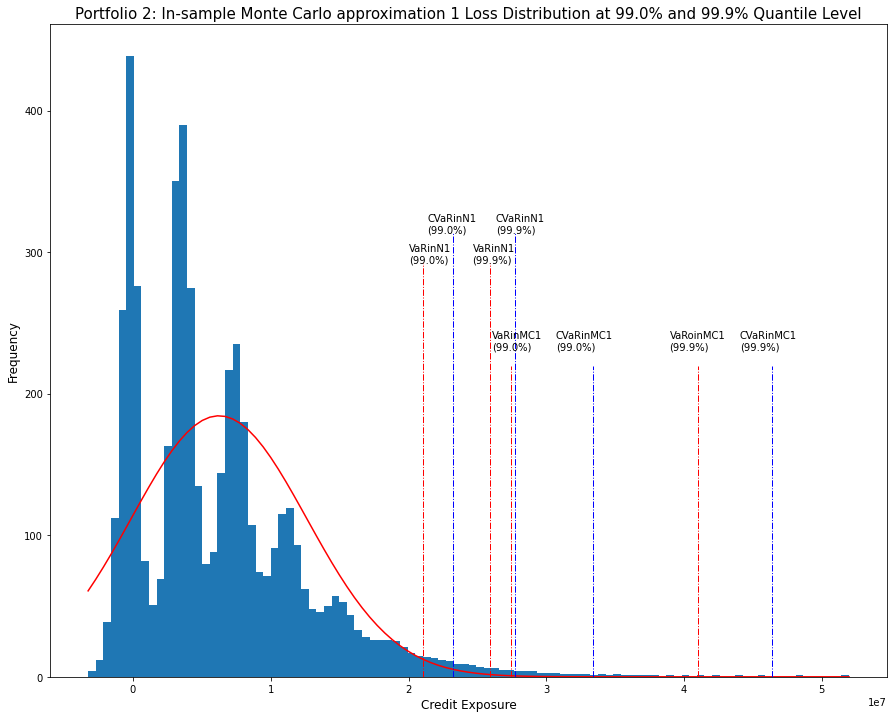

In [102]:
VaRinMC1_p2_99 = np.mean(VaRinMC1[1, 0])
VaRinMC1_p2_99_9 = np.mean(VaRinMC1[1, 1])
CVaRinMC1_p2_99 = np.mean(CVaRinMC1[1, 0])
CVaRinMC1_p2_99_9 = np.mean(CVaRinMC1[1, 1])



plt.figure(figsize=(15,12))
frequencyCounts, binLocations, patches = plt.hist(port_loss_inMC1_p2, 100)
normf = (1 / (np.std(port_loss_inMC1_p2) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(port_loss_inMC1_p2)) / np.std(port_loss_inMC1_p2)) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth=1.5)
plt.plot([VaRinMC1_p2_99, VaRinMC1_p2_99], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinMC1_p2_99, max(frequencyCounts) / 1.9, 'VaRinMC1\n(99.0%)')
plt.plot([VaRinMC1_p2_99_9, VaRinMC1_p2_99_9], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinMC1_p2_99_9, max(frequencyCounts) / 1.9, 'VaRoinMC1\n(99.9%)')
plt.plot([CVaRinMC1_p2_99, CVaRinMC1_p2_99], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.text(0.92 * CVaRinMC1_p2_99, max(frequencyCounts) / 1.9, 'CVaRinMC1\n(99.0%)')
plt.plot([CVaRinMC1_p2_99_9, CVaRinMC1_p2_99_9], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.text(0.95 * CVaRinMC1_p2_99_9, max(frequencyCounts) / 1.9, 'CVaRinMC1\n(99.9%)')

# Normal distribution of Monte Carlo approximation 1, portfolio 2 
VaRinN1_p2_99 = np.mean(VaRinN1[1, 0])
VaRinN1_p2_99_9 = np.mean(VaRinN1[1, 1])
CVaRinN1_p2_99 = np.mean(CVaRinN1[1, 0])
CVaRinN1_p2_99_9 = np.mean(CVaRinN1[1, 1])

plt.plot([VaRinN1_p2_99, VaRinN1_p2_99], [0, max(frequencyCounts)/1.5], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinN1_p2_99, max(frequencyCounts) / 1.5, 'VaRinN1\n(99.0%)')
plt.plot([VaRinN1_p2_99_9, VaRinN1_p2_99_9], [0, max(frequencyCounts)/1.5], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinN1_p2_99_9, max(frequencyCounts) / 1.5, 'VaRinN1\n(99.9%)')
plt.plot([CVaRinN1_p2_99, CVaRinN1_p2_99], [0, max(frequencyCounts)/1.4], color='b', linewidth=1, linestyle='-.')
plt.text(0.92 * CVaRinN1_p2_99, max(frequencyCounts) / 1.4, 'CVaRinN1\n(99.0%)')
plt.plot([CVaRinN1_p2_99_9, CVaRinN1_p2_99_9], [0, max(frequencyCounts)/1.4], color='b', linewidth=1, linestyle='-.')
plt.text(0.95 * CVaRinN1_p2_99_9, max(frequencyCounts) / 1.4, 'CVaRinN1\n(99.9%)')


plt.title('Portfolio 2: In-sample Monte Carlo approximation 1 Loss Distribution at 99.0% and 99.9% Quantile Level', fontsize=15)
plt.xlabel('Credit Exposure', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12);
plt.savefig('p2_mc1.png')

### 3) MC2 

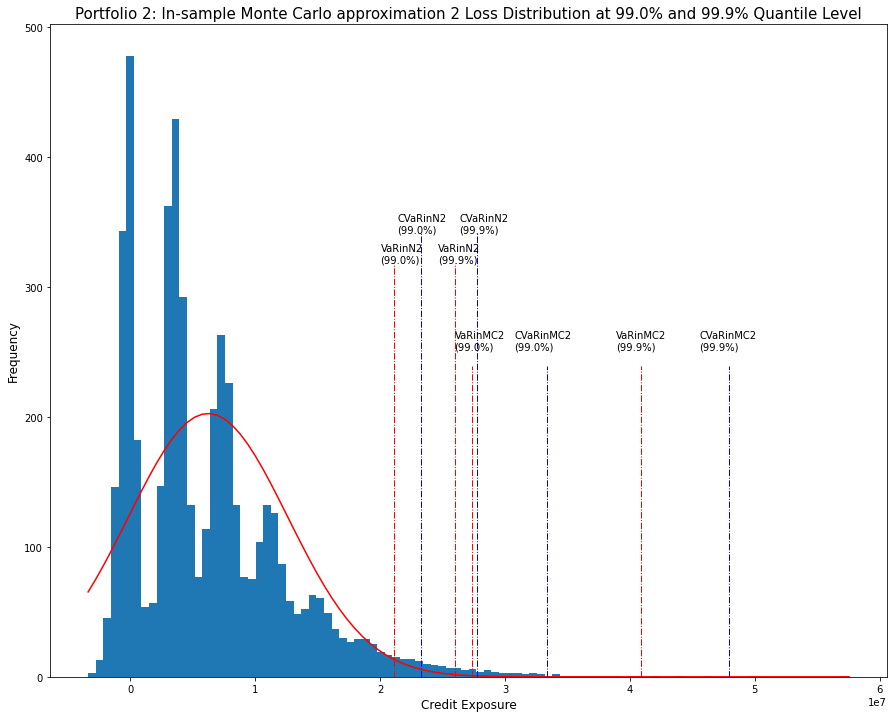

In [103]:
VaRinMC2_p2_99 = np.mean(VaRinMC2[1, 0])
VaRinMC2_p2_99_9 = np.mean(VaRinMC2[1, 1])
CVaRinMC2_p2_99 = np.mean(CVaRinMC2[1, 0])
CVaRinMC2_p2_99_9 = np.mean(CVaRinMC2[1, 1])



plt.figure(figsize=(15,12))
frequencyCounts, binLocations, patches = plt.hist(port_loss_inMC2_p2, 100)
normf = (1 / (np.std(port_loss_inMC2_p2) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(port_loss_inMC2_p2)) / np.std(port_loss_inMC2_p2)) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth=1.5)
plt.plot([VaRinMC2_p2_99, VaRinMC2_p2_99], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinMC2_p2_99, max(frequencyCounts) / 1.9, 'VaRinMC2\n(99.0%)')
plt.plot([VaRinMC2_p2_99_9, VaRinMC2_p2_99_9], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinMC2_p2_99_9, max(frequencyCounts) / 1.9, 'VaRinMC2\n(99.9%)')
plt.plot([CVaRinMC2_p2_99, CVaRinMC2_p2_99], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.text(0.92 * CVaRinMC2_p2_99, max(frequencyCounts) / 1.9, 'CVaRinMC2\n(99.0%)')
plt.plot([CVaRinMC2_p2_99_9, CVaRinMC2_p2_99_9], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.text(0.95 * CVaRinMC2_p2_99_9, max(frequencyCounts) / 1.9, 'CVaRinMC2\n(99.9%)')

# Normal distribution of Monte Carlo approximation 1, portfolio 1 
VaRinN2_p2_99 = np.mean(VaRinN2[1, 0])
VaRinN2_p2_99_9 = np.mean(VaRinN2[1, 1])
CVaRinN2_p2_99 = np.mean(CVaRinN2[1, 0])
CVaRinN2_p2_99_9 = np.mean(CVaRinN2[1, 1])

plt.plot([VaRinN2_p2_99, VaRinN2_p2_99], [0, max(frequencyCounts)/1.5], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinN2_p2_99, max(frequencyCounts) / 1.5, 'VaRinN2\n(99.0%)')
plt.plot([VaRinN2_p2_99_9, VaRinN2_p2_99_9], [0, max(frequencyCounts)/1.5], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinN2_p2_99_9, max(frequencyCounts) / 1.5, 'VaRinN2\n(99.9%)')
plt.plot([CVaRinN2_p2_99, CVaRinN2_p2_99], [0, max(frequencyCounts)/1.4], color='b', linewidth=1, linestyle='-.')
plt.text(0.92 * CVaRinN2_p2_99, max(frequencyCounts) / 1.4, 'CVaRinN2\n(99.0%)')
plt.plot([CVaRinN2_p2_99_9, CVaRinN2_p2_99_9], [0, max(frequencyCounts)/1.4], color='b', linewidth=1, linestyle='-.')
plt.text(0.95 * CVaRinN2_p2_99_9, max(frequencyCounts) / 1.4, 'CVaRinN2\n(99.9%)')


plt.title('Portfolio 2: In-sample Monte Carlo approximation 2 Loss Distribution at 99.0% and 99.9% Quantile Level', fontsize=15)
plt.xlabel('Credit Exposure', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12);
plt.savefig('p2_mc2.png')

In [106]:
VaRout

array([[37668009.00000001, 55197450.92      ],
       [27507296.2386607 , 42508340.48810916]])

In [108]:
VaRinN1[0,0]

array([25567636.51481311, 24812493.60070532, 26901266.02001394,
       25911827.6317153 , 27085562.17846486, 27198385.5142693 ,
       26186173.94632644, 26973114.91731528, 26948535.77410878,
       25972257.37211554, 27684841.38459555, 26248927.47597661,
       25434931.08068235, 25751639.50928427, 26949087.3779375 ,
       25999447.65104803, 25886227.38161235, 25366087.51848817,
       25034294.42614713, 25498407.98546238, 25547524.64122842,
       27299536.25186574, 25932133.8168076 , 26258012.79849093,
       26736454.25926151, 25250540.60101755, 26980197.91794835,
       25528867.03506756, 27425397.34549935, 27368806.4651193 ,
       26575222.31970495, 25982004.65279244, 25473346.0627717 ,
       25488934.65838385, 24530801.85823058, 26043317.06899717,
       25439638.07866831, 26761852.92987406, 26448214.90633757,
       26250863.29540969, 25749059.19513773, 25876963.21407063,
       25155570.2034126 , 27172172.01636482, 26232002.91750891,
       26684525.99985442, 25882242.89668